<h1> Big Mart Sales Prediction </h1>

The main goal of this competition is to create a model that will be used to understand the properties of products and stores which play a key role in increasing sales.

<h3>Hypothesis Generation</h3>

Before we look at the data let us try to hypothesize what properties of stores and products may play a role in increasing sales.

<b>Store Level hypothesis</b>

-Location of Store

-Population of area

-Competition in area

-Type of City

-Store size

-Customer purchasing trends

-Store's feel or ambiance 

-Advertisement


<b>Product Level hypothesis</b>

-Calorie count

-Brand

-Packaging

-Location in store

-Advertisement

-On sale or not

-Usefulness of product

-Display area

<h3>Data Exploration</h3>

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Read files:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)


(8523, 13) (5681, 12) (14204, 13)


In [294]:
print(data.columns)

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Type', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'source'],
      dtype='object')


Some of these columns can be attributed to the hypothesis we have generated earlier. For example:

Fat_content is similar to calorie count

Item_visability, Outlet_location, Outlet_location_type, Outlet_size, Outlet_type and a few others are ones that we have come up with as well.

In [295]:
#Looking for misisng values
data.apply(lambda x: sum(x.isnull()))

#Item_Outlet_Sales is our target variable and they are missing from the test set, So we needn't worry about that variable
#We will clean Item_weight and Outlet_size shortly

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [296]:
data.describe()
#Item Visability has a minimum value of 0 which doesn't make sense since if it is in the store it should be visable
#Outlet_establishment_year could be transformed to better fit our model because the year it opened could affect sales

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [297]:
data.apply(lambda x: len(x.unique()))
#Here we can see that we are dealing with 1559 different items at 10 locations as well as 16 different types of items.

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [298]:
#Now we will dive deeper into each categorical column and find the value counts for each.
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

In [299]:
#Item_Fat_Content: We can see that some data is mislabeled and we will need to fix that
#Item_type: we might be able to combine a few groups in the item_type that have lower values
#Outlet_type: we will also consider combining Grocery Store, Supermarket Type3 and Supermarket Type2

<h3>Data Cleaning</h3>

In [300]:
#Missing Values: Item_Weight, Outlet_Size
#Item_Weight
Item_weight_avg = data.pivot_table(values='Item_Weight',index='Item_Identifier')
missing_val = data.Item_Weight.isnull()
print ('Before missing count: %d'% sum(missing_val))
data.loc[missing_val,'Item_Weight'] = data.loc[missing_val,'Item_Identifier'].apply(lambda x: Item_weight_avg[x])
print ('After missing count: %d' % sum(data.Item_Weight.isnull()))

Before missing count: 2439
After missing count: 0


In [301]:
#Outlet_Size
missing_val = data.Outlet_Size.isnull()
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:x.value_counts().index[0]))
print(outlet_size_mode)
print ('Before missing count: %d'% sum(data.Outlet_Size.isnull()))
data.loc[missing_val,'Outlet_Size'] = data.loc[missing_val,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print ('After missing count: %d' % sum(data['Outlet_Size'].isnull()))

Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object
Before missing count: 4016
After missing count: 0


In [302]:
#Item_Fat_Content
#As we saw before there were some inconsistent labeling of fat content amongst items, lets fix that
print(data['Item_Fat_Content'].value_counts())
data['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat': 'Low Fat'},inplace=True)
print(data['Item_Fat_Content'].value_counts())

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


<h3>Feature Engineering</h3>

In [303]:
#Consider merging Outlet_Type
print(data['Outlet_Type'].value_counts())
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')
#There is a significant difference between the sales of these Types that we will leave them as is.

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64


Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

In [304]:
#Item Visibility has some 0 values which do not make sense, we will treat them as missing information
#and input the average visability
visibility_avg = data.pivot_table(values='Item_Visibility', columns='Item_Identifier',aggfunc=(lambda x:x.mean()))
missing_val = data['Item_Visibility'] == 0
print('Before missing counts %d' % sum(missing_val))
data.loc[missing_val,'Item_Visibility'] = data.loc[missing_val,'Item_Identifier'].apply(lambda x: visibility_avg[x])
print('After Missing counts %d' % sum(data['Item_Visibility']== 0))

Before missing counts 879
After Missing counts 0


In [305]:
#Although we believe that a higher visibility would translate to higher sales, instead of measuring this on absolute
#terms it could be useful to measure visibility against the visibility of that item in other stores
#We will use the visibility_avg we created before
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [306]:
#Item_Type
#I would like to combine these in some way because there are currently 16 different categories of items
#according to the Item_Identifier column, each item has a prefix of FD, DR, or NC. (Food, Drink, Non-Consumable)
#I'll just use these as our groupings.

#Extract the group
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

#Also now that we have identified that there are some Non-Consumable Products,
#It does not make sense to for them to have a fat content
data.loc[data['Item_Type_Combined']=='Non-Consumable','Item_Fat_Content'] = 'Non-Edible'
print(data['Item_Fat_Content'].value_counts())

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


In [307]:
#Outlet_Establishment_Year
#It could be useful to know how long a store has been open as older stores may have higher sales due to a loyal customer base.
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [308]:
#One-Hot Encoding of categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [309]:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [310]:
#Lets put our data back into their train and test sets
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)
#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]
#Drop target and source
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export cleaned datasets for future use
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

<h3>Model Building</h3>

In [311]:
#First since I want to try out a few models, I'll build a model function to make my life easier

In [312]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def fit_model(algorithm, d_train, d_test, predictors, target, IDcol):
    algorithm.fit(d_train[predictors], d_train[target])
    d_train_predictions = algorithm.predict(d_train[predictors])
    
    cross_validation_score = cross_validation.cross_val_score(algorithm,d_train[predictors],d_train[target],cv=20,scoring='mean_squared_error')
    cross_validaiton_score = np.sqrt(np.abs(cross_validation_score))
    #Print Report
    print("\nModel Report")
    print("Root Mean Squared Error : %.4g" % np.sqrt(metrics.mean_squared_error(d_train[target].values, d_train_predictions)))
    print("Cross Validation Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cross_validaiton_score),np.std(cross_validaiton_score),np.min(cross_validaiton_score),np.max(cross_validaiton_score)))
    
    d_test[target] = algorithm.predict(d_test[predictors])
    
    #Export submission file:
    IDcol.append(target)
    result = pd.DataFrame({ x: d_test[x] for x in IDcol})
    return result


Model Report
Root Mean Squared Error : 1127
Cross Validation Score : Mean - 1129 | Std - 43.51 | Min - 1075 | Max - 1210


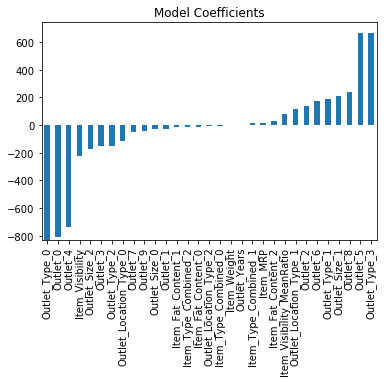

In [313]:
#Linear Regression
from sklearn.linear_model import LinearRegression, Ridge
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
result1 = fit_model(alg1, train, test, predictors, target, IDcol)
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
Root Mean Squared Error : 1129
Cross Validation Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


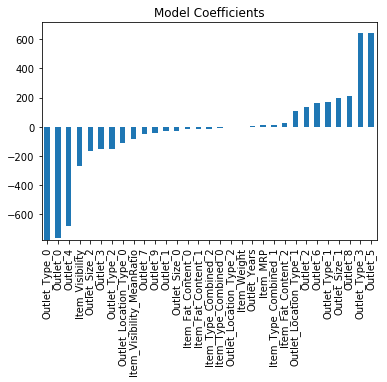

In [314]:
#Because the coeficients are quite high in magnitude this indicates overfitting, lets try the Ridge LR model
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
result2 =fit_model(alg2, train, test, predictors, target, IDcol)
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')


Model Report
Root Mean Squared Error : 1058
Cross Validation Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


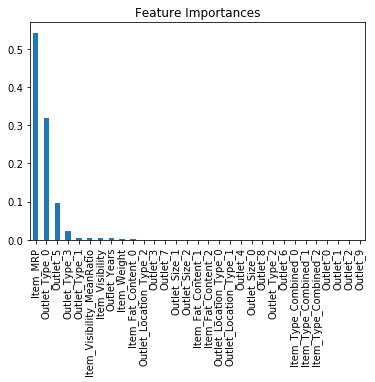

In [315]:
#There doesn't seem to be much difference, lets move on
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
result3 = fit_model(alg3, train, test, predictors, target, IDcol)
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')



Model Report
Root Mean Squared Error : 1071
Cross Validation Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


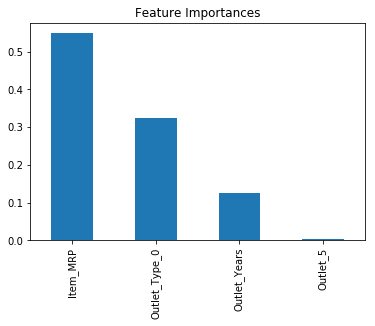

In [316]:
#With a RMSE of 1058 and a CV_Score of 1091 I think we are still over fitting, Let's try a decision tree
#with the top 4 variables
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
result4 = fit_model(alg4, train, test, predictors, target, IDcol)
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')


Model Report
Root Mean Squared Error : 1073
Cross Validation Score : Mean - 1084 | Std - 43.68 | Min - 1021 | Max - 1161


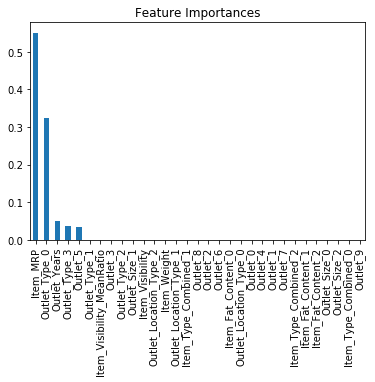

In [319]:
#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
result5 = fit_model(alg5, train, test, predictors, target, IDcol)
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')


Model Report
Root Mean Squared Error : 1068
Cross Validation Score : Mean - 1083 | Std - 43.82 | Min - 1019 | Max - 1161


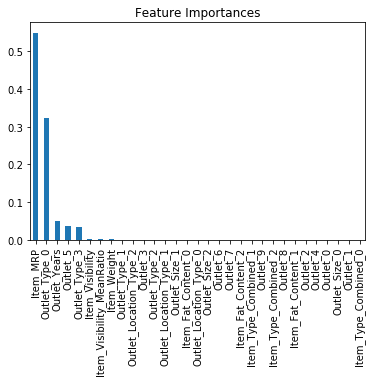

In [320]:
#one more random forest with a max depth of 6 and 400 trees
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
result6 = fit_model(alg6, train, test, predictors, target, IDcol)
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')